# SVC kernels: polynomial

In [9]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from time import time
import numpy as np

In [10]:
# get features and labels
data = pd.read_pickle('pifsc_embeddings2.pickle')
features = dict(data)
data = pd.read_pickle('pifsc_embeddings.pkl')
features.update(data)

cols = ["species","image","distinctiveness","quality"]
labels1 = pd.read_csv('pifsc_labels_detail.csv')[cols]

cols = ["species","filename","distinctiveness","quality"]
labels2 = pd.read_csv('pifsc_labels2.csv')[cols]
labels2.columns = ["species","image","distinctiveness","quality"]

labels = pd.concat([labels1, labels2]).reset_index(drop=True)

In [11]:
# clean labels
is_na = labels.distinctiveness.isna()
labels = labels.loc[~is_na]
labels = labels.drop_duplicates(subset='image', keep='first')
# labels.reset_index(drop=False, inplace=True)

# clean features
imgs = labels.image.tolist()
features = {k: v for k, v in features.items() if k in imgs}
assert len(features) == len(labels)

In [12]:
# get data, split
Y = labels.distinctiveness
X = np.array([features[i] for i in labels.image])
# species = labels.species.astype('category').cat.codes
# X = np.insert(X, 0, species, axis=1)
# sc = StandardScaler()
# X = sc.fit_transform(X)


In [13]:
# train Logistic regression
classifiers = [SVC(class_weight='balanced', random_state=42, kernel='poly', degree=2),
               SVC(class_weight='balanced', random_state=42, kernel='poly', degree=3),
               SVC(class_weight='balanced', random_state=42, kernel='poly', degree=4),
               SVC(class_weight='balanced', random_state=42, kernel='poly', degree=5)]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# for clf in classifiers:
#     # print(clf.kernel)
#     clf.fit(X_train, Y_train)

In [14]:
preds = []
for clf in classifiers:
    pred = cross_val_predict(clf, X, Y, n_jobs=-1, cv=cv)
    preds.append(pred)
    print(f'deg={clf.degree}'.center(53, '-'))
    print(classification_report(Y, pred))

------------------------deg=2------------------------
              precision    recall  f1-score   support

         1.0       0.91      0.93      0.92      1152
         2.0       0.95      0.95      0.95      2343
         3.0       0.71      0.57      0.63        44
         4.0       0.91      0.57      0.70        37

    accuracy                           0.94      3576
   macro avg       0.87      0.75      0.80      3576
weighted avg       0.94      0.94      0.93      3576

------------------------deg=3------------------------
              precision    recall  f1-score   support

         1.0       0.95      0.90      0.92      1152
         2.0       0.93      0.98      0.95      2343
         3.0       0.81      0.30      0.43        44
         4.0       0.90      0.24      0.38        37

    accuracy                           0.93      3576
   macro avg       0.90      0.60      0.67      3576
weighted avg       0.93      0.93      0.93      3576

----------------------

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

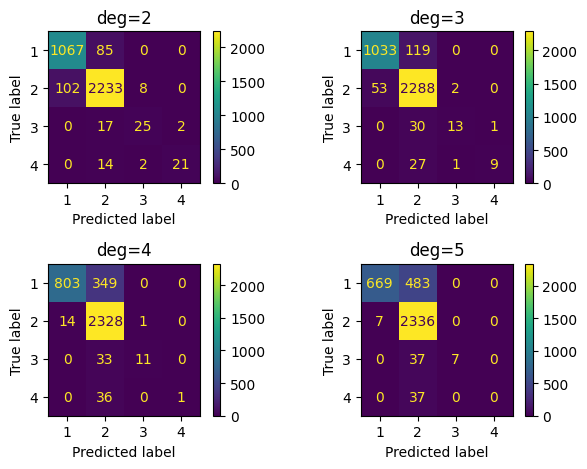

In [15]:
# results
fig, axes = plt.subplots(2, 2)
for i, (clf, ax) in enumerate(zip(classifiers, axes.flatten())):
    cm = confusion_matrix(Y, preds[i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4])
    disp.plot(ax=ax)
    ax.title.set_text(f'deg={clf.degree}')
plt.tight_layout()

In [16]:
print(Y_test.value_counts())

distinctiveness
2.0    586
1.0    288
3.0     11
4.0      9
Name: count, dtype: int64
